## Imports

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

import warnings
warnings.filterwarnings('ignore')

## Forecasting with Prophet

Forecasting procedure developed by Facebook. [webpage](https://facebook.github.io/prophet/)

### Total traffic forecast

In [30]:
# Separe data in train and validation
df_tot = df_tot.rename(columns={'datetime':'ds', 'traffic':'y'})
df_train = df_tot[df_tot.ds < '2017-01-01']
df_val = df_tot[~(df_tot.ds < '2017-01-01')]

In [159]:
# Fitting model on training data (years: 2010 ~ 2016)
m = Prophet()
m.fit(df_train)

23:21:36 - cmdstanpy - INFO - Chain [1] start processing
23:21:36 - cmdstanpy - INFO - Chain [1] done processing


In [160]:
# Forecasting
future = m.make_future_dataframe(periods=len(df_val), include_history=False)
forecast = m.predict(future)

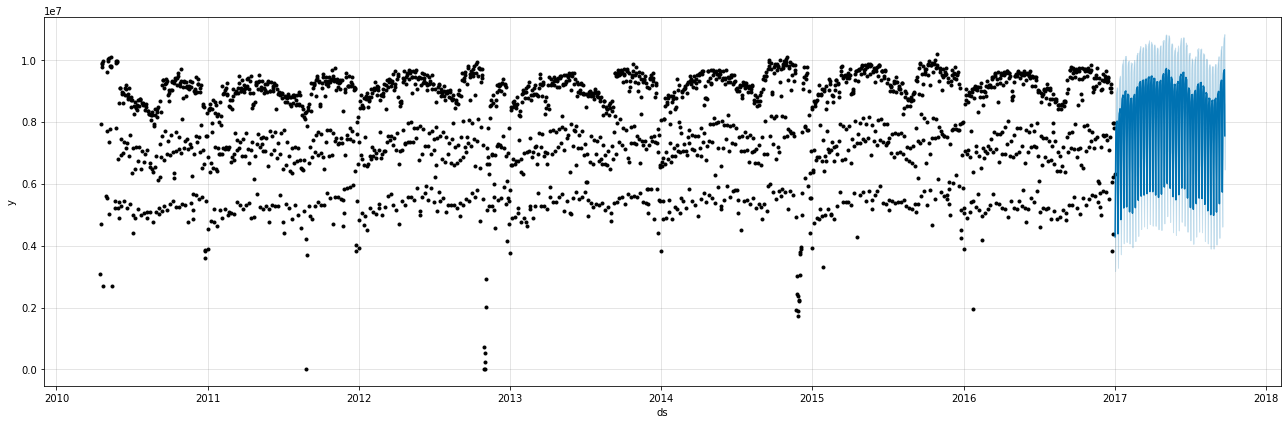

In [161]:
fig1 = m.plot(forecast, figsize=(18, 6))

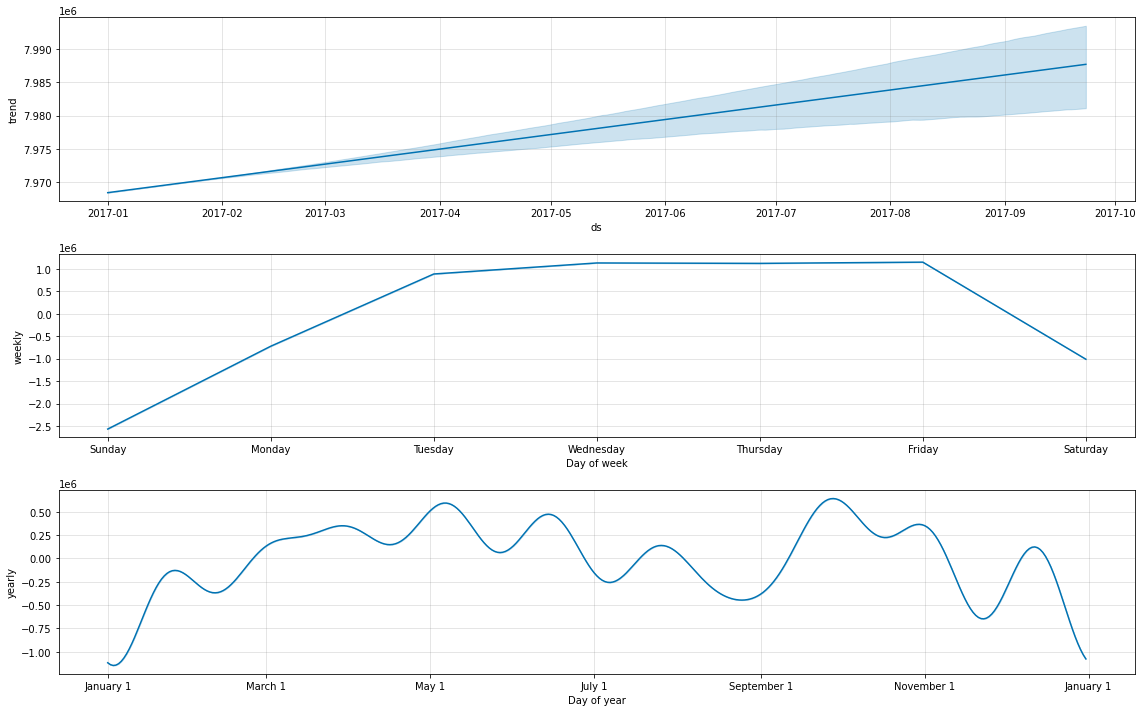

In [162]:
fig2 = m.plot_components(forecast, figsize=(16, 10))

#### Evaluating results

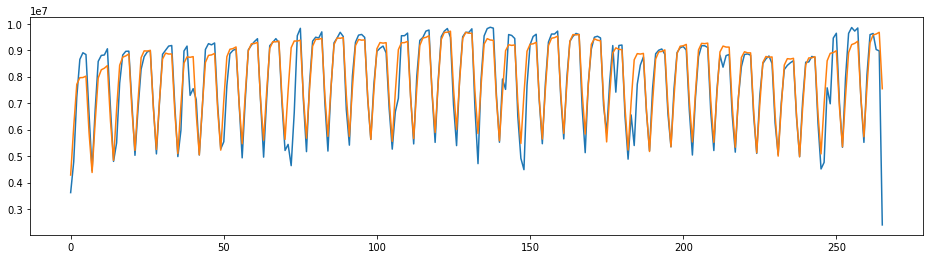

In [163]:
y_true = df_val.y.values
y_pred = forecast.yhat.values

plt.figure(figsize=(16, 4))
plt.plot(y_true)
plt.plot(y_pred)

In [164]:
m = Prophet()
m.fit(df_tot.rename(columns={'datetime':'ds', 'traffic':'y'}))

cutoffs = pd.to_datetime(['2014-01-01', '2015-01-01', '2016-01-01', '2016-07-01'])
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', disable_tqdm=True)

23:21:38 - cmdstanpy - INFO - Chain [1] start processing
23:21:38 - cmdstanpy - INFO - Chain [1] done processing
23:21:38 - cmdstanpy - INFO - Chain [1] start processing
23:21:38 - cmdstanpy - INFO - Chain [1] done processing
23:21:41 - cmdstanpy - INFO - Chain [1] start processing
23:21:41 - cmdstanpy - INFO - Chain [1] done processing
23:21:44 - cmdstanpy - INFO - Chain [1] start processing
23:21:44 - cmdstanpy - INFO - Chain [1] done processing
23:21:47 - cmdstanpy - INFO - Chain [1] start processing
23:21:47 - cmdstanpy - INFO - Chain [1] done processing


In [165]:
# Compute performance metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,7.008345e+11,8.371586e+05,5.278545e+05,0.091458,0.045334,0.078842,0.897260
1,38 days,6.748495e+11,8.214923e+05,5.090985e+05,0.088240,0.044088,0.075833,0.907534
2,39 days,6.379037e+11,7.986888e+05,4.862793e+05,0.083872,0.042635,0.071797,0.914384
3,40 days,6.033649e+11,7.767657e+05,4.663668e+05,0.079959,0.035579,0.068179,0.921233
4,41 days,5.890060e+11,7.674673e+05,4.559771e+05,0.078266,0.035579,0.066400,0.924658
...,...,...,...,...,...,...,...,...
324,361 days,3.872276e+12,1.967810e+06,1.129422e+06,0.294070,0.071654,0.179987,0.777397
325,362 days,3.824450e+12,1.955620e+06,1.114246e+06,0.286680,0.068945,0.175685,0.780822
326,363 days,3.711321e+12,1.926479e+06,1.087431e+06,0.274561,0.065707,0.169566,0.787671
327,364 days,3.473905e+12,1.863842e+06,1.033402e+06,0.258806,0.053342,0.160665,0.804795


### Forecast by stations and lines

In [40]:
def train_and_predict(df, title):
    # Training
    m = Prophet()
    m.fit(df.rename(columns={'datetime':'ds', 'traffic':'y'}))

    # Forecasting
    future = m.make_future_dataframe(periods=365, include_history=True)
    forecast = m.predict(future)
    
    # Plot
    fig = m.plot(forecast, figsize=(18, 4))
    ax = fig.gca().set_title(title, size=22)

11:37:27 - cmdstanpy - INFO - Chain [1] start processing
11:37:28 - cmdstanpy - INFO - Chain [1] done processing
11:37:31 - cmdstanpy - INFO - Chain [1] start processing
11:37:31 - cmdstanpy - INFO - Chain [1] done processing
11:37:35 - cmdstanpy - INFO - Chain [1] start processing
11:37:35 - cmdstanpy - INFO - Chain [1] done processing


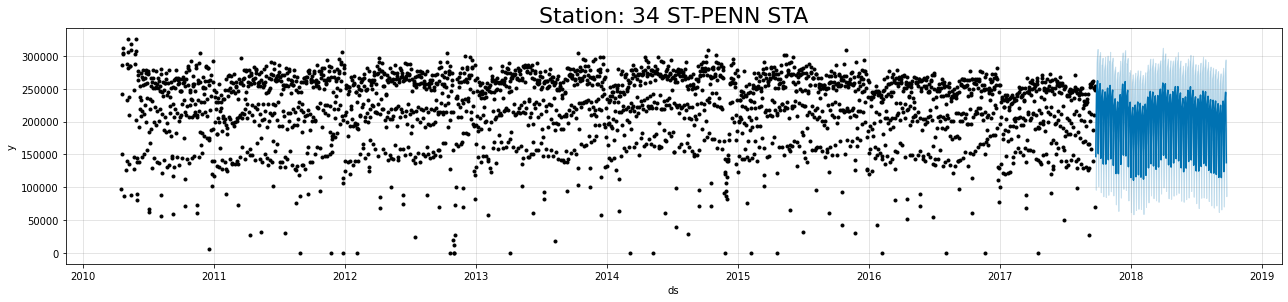

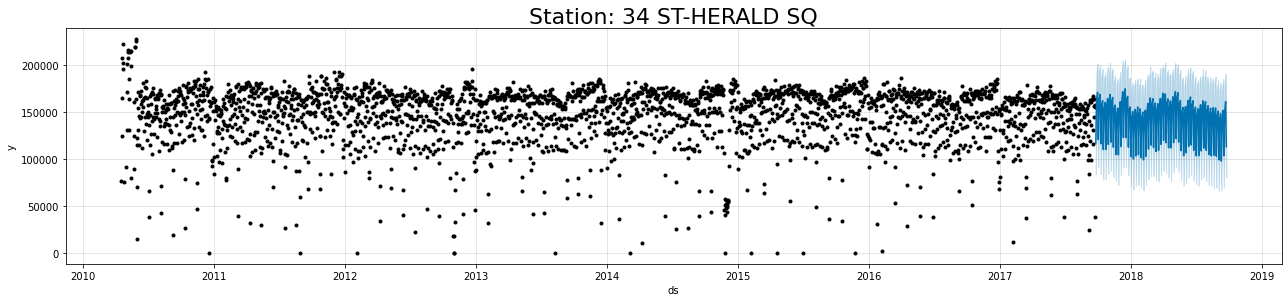

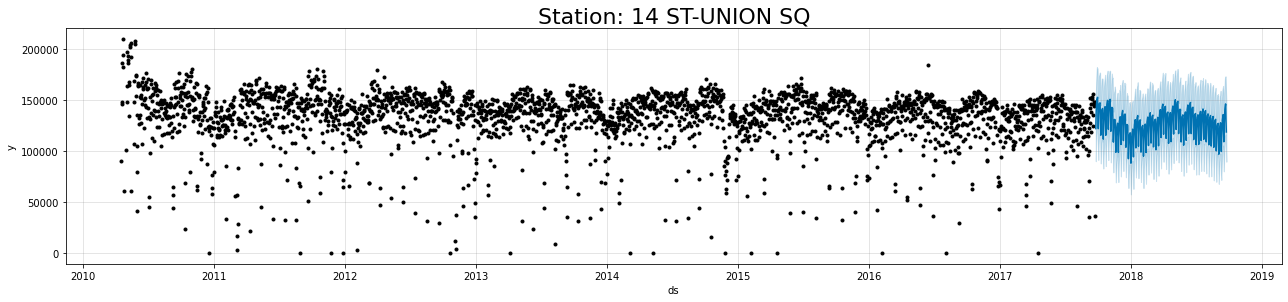

In [24]:
# Stations
df_highest_st_traffic = df_st.groupby('station')['traffic'].sum().sort_values(ascending=False)
for station in df_highest_st_traffic[:3].keys():
    train_and_predict(df_st[df_st['station']==station], title=f'Station: {station}')

In [21]:
# Lines
df_highest_ln_traffic = df_ln.groupby('linename')['traffic'].sum().sort_values(ascending=False)
for line in df_highest_ln_traffic[:3].keys():
    train_and_predict(df_ln[df_ln['linename']==line], title=f'Line: {line}')

NameError: name 'train_and_predict' is not defined

11:45:58 - cmdstanpy - INFO - Chain [1] start processing
11:45:58 - cmdstanpy - INFO - Chain [1] done processing


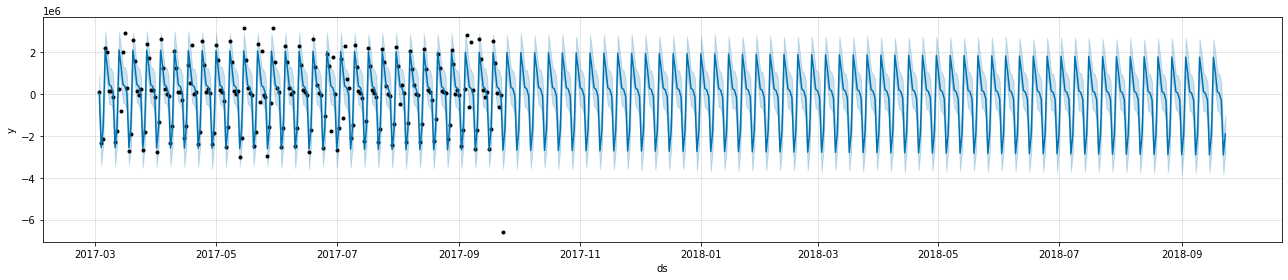

In [42]:
# df_tot.y = df_tot.y.diff().fillna(0)
train_and_predict(df_tot[2500:], title='')


11:48:17 - cmdstanpy - INFO - Chain [1] start processing
11:48:17 - cmdstanpy - INFO - Chain [1] done processing


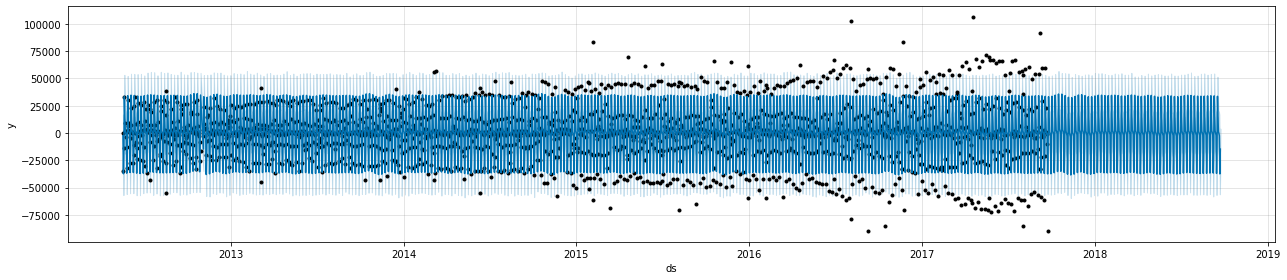

In [49]:
x = df_ln[df_ln.linename=='2345ACJZ'][-2000:].drop('linename', axis=1)
# df_tot.y = df_tot.y.diff().fillna(0)
x.traffic = x.traffic.diff().fillna(0)
train_and_predict(x.rename(columns={'datetime':'ds', 'traffic':'y'}), title='')
